In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB



In [8]:
# This block examines the alpha hyperparameter, which is the amount of laplace smoothing
# Load data
df = pd.read_pickle("untracked_data/data_prepro_train_01.pkl")

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Range of alpha values to test (logarithmic scale)
alphas = np.logspace(-3, 1, 10)

results = []

for a in alphas:
    model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=a))
    scores = cross_val_score(model, df['text'], df['label'], cv=kf, scoring='accuracy')
    results.append({"alpha": a, "mean_accuracy": scores.mean()})

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Create Seaborn lineplot
sns.set_theme(style="whitegrid", font_scale=1.2)
ax = sns.lineplot(
    data=df_results,
    x="alpha",
    y="mean_accuracy",
    marker="o"
)

# Customize plot
ax.set_xscale("log")
ax.set_title("Effect of Alpha on Naive Bayes Accuracy (10-Fold CV)")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Mean Accuracy")

# Show the plot
sns.despine()


FileNotFoundError: [Errno 2] No such file or directory: 'data_prepro01.pkl'

Best percentile = 5% | Mean accuracy = 0.8484


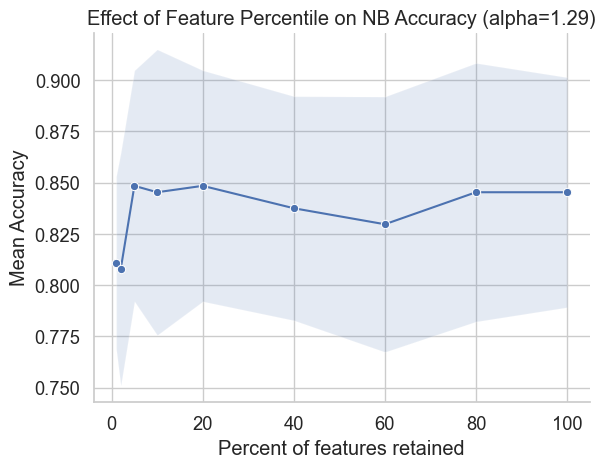

In [17]:
# This block examines top-k feature selection, as percentile of the ordered top words

# Load data
df = pd.read_pickle("data_prepro01.pkl")

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Use best alpha from prev cell
best_alpha = float(df_results.loc[df_results['mean_accuracy'].idxmax(), 'alpha'])


# Percentile grid (percent of features kept)
percentiles = [1, 2, 5, 10, 20, 40, 60, 80, 100]

results = []
pipe = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 1))),
    ("sp", SelectPercentile(score_func=chi2, percentile=percentiles[0])),
    ("nb", MultinomialNB(alpha=best_alpha)),
])

for p in percentiles:
    pipe.set_params(sp__percentile=p)
    scores = cross_val_score(pipe, df["text"], df["label"], cv=kf, scoring="accuracy")
    results.append({"percentile": p, "mean_accuracy": scores.mean(), "std": scores.std()})

df_p = pd.DataFrame(results)

# Plot accuracy vs percentile 
sns.set_theme(style="whitegrid", font_scale=1.2)
ax = sns.lineplot(data=df_p, x="percentile", y="mean_accuracy", marker="o")
ax.fill_between(
    df_p["percentile"],
    df_p["mean_accuracy"] - df_p["std"],
    df_p["mean_accuracy"] + df_p["std"],
    alpha=0.15,
)
ax.set_title(f"Effect of Feature Percentile on NB Accuracy (alpha={best_alpha:.3g})")
ax.set_xlabel("Percent of features retained")
ax.set_ylabel("Mean Accuracy")
sns.despine()

# Report best percentile
best_row = df_p.loc[df_p['mean_accuracy'].idxmax()]
print(f"Best percentile = {best_row.percentile:.0f}% | Mean accuracy = {best_row.mean_accuracy:.4f}")



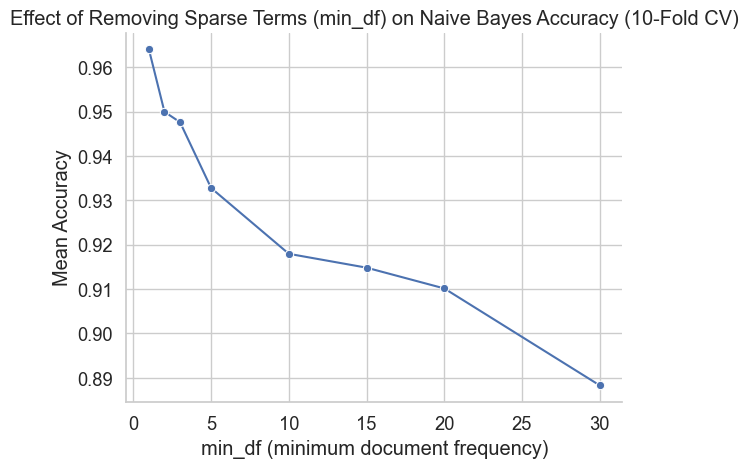

In [4]:
# Load data
df = pd.read_pickle("data_prepro01.pkl")

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Range of min_df values to test (removing increasingly sparse terms)
# Integers mean "term must appear in at least this many documents"
min_df_values = [1, 2, 3, 5, 10, 15, 20, 30]

results = []

for m in min_df_values:
    model = make_pipeline(
        CountVectorizer(min_df=m),
        MultinomialNB(alpha=1.0) 
    )
    scores = cross_val_score(model, df['text'], df['label'], cv=kf, scoring='accuracy')
    results.append({"min_df": m, "mean_accuracy": scores.mean()})

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Plot
sns.set_theme(style="whitegrid", font_scale=1.2)
ax = sns.lineplot(
    data=df_results,
    x="min_df",
    y="mean_accuracy",
    marker="o"
)

# Customize plot
ax.set_title("Effect of Removing Sparse Terms (min_df) on Naive Bayes Accuracy (10-Fold CV)")
ax.set_xlabel("min_df (minimum document frequency)")
ax.set_ylabel("Mean Accuracy")

sns.despine()